# А/B тестироване


В распоряжении датасет для A/B-тестирования - это синтетический набор данных, сгенерированный с использованием техники случайной выборки из библиотеки NumPy. Датасет имитирует информацию о посещениях пользователями розничного веб-сайта, работающего по всей Великобритании. <br>
Пользователи разделены на две группы - группа А (контрольная) и группа В (тестовая). <br>
представим, что компания хочет протестировать следующее изменение на сайте: изменить цвет фона с белого на черный и проверить, как данное изменение повлияет на время, которое пользователи проводят на сайте. <br>
Этот вопрос ставится для достижения основной цели анализа - повышения вовлеченности пользователей. <br>
В данном случае: <br>
- Белый цвет присваивается группе А, как фоновый цвет страницы
- Черный цвет присваивается группе В, как фоновый цвет страницы


### Цель <br>
Целью анализа является выявление того, является ли статистически значимым увеличение просмотров страницы, если применить новое оформление. Для этого проведем А/B тестирование

### Задачи 
- Подготовка данных 
- Анализ результатов A/B тестирования
- Выводы

### Описание столбцов <br>
- User ID: Уникальный идентификатор пользователя  
- Group: Указывает на группу — контрольная (A) или тестовая (B)   
- Page Views: Количество просмотренных страниц за сессию  
- Time Spent: Общее время (в секундах), проведённое пользователем на сайте  
- Conversion: Завершил ли пользователь целевое действие (Да/Нет)  
- Device: Тип устройства, с которого пользователь зашёл на сайт 
- Location: Регион в Великобритании, где находится пользователь

### Импорт необходимых библиотек и обзор данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('ab_testing.csv')

In [7]:
data.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


Для удобства переименуем столбцы и сделаем все буквы строчными

In [9]:
data.isna().sum()

User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

Датасет не содержит пропусков

## Предобработка данных

Приведем названия столбцов в удобный вид для дальнейшей работы (уберем пробелы и все буквы сделаем строчными)

In [17]:
def name_col(col):
    return '_'.join(col.lower().split(' '))
new_cols = []
for col in data.columns:
    new_cols.append(name_col(col))

data.columns = new_cols


Заменим значение в столбце conversion на 1 (Yes) и 0 (No)

In [21]:
data['conversion']=data['conversion'].apply(lambda x: 1 if x=='Yes' else 0)

In [22]:
data

,user_id,group,page_views,time_spent,conversion,device,location
0,14292,B,3,424,0,Mobile,Northern Ireland
1,11682,A,9,342,0,Mobile,Scotland
2,19825,A,2,396,0,Desktop,Northern Ireland
3,16080,B,4,318,0,Desktop,Wales
4,18851,A,1,338,1,Desktop,Scotland
...,...,...,...,...,...,...,...
4995,16360,B,12,313,0,Mobile,Wales
4996,18084,B,10,313,0,Desktop,Northern Ireland
4997,12063,A,11,156,0,Desktop,England
4998,18647,B,13,346,0,Desktop,Wales


## Анализ результатов А/В тестирования

### Анализ различий конверсии между группами А и В

Сформулируем гипотезы: <br>
Н0: Изменение оформления никак не повляет на конверсию <br>
Н1: Изменение оформления поспособствует увеличению конверсии

Построим для начала таблицу со значениями конверсий для каждой из групп

In [35]:
round(pd.crosstab(data['group'], data['conversion'], normalize='index'),4) *100

conversion,0,1
group,,
A,94.60,5.40
B,85.93,14.07


Построим график изменение конверсий по группам

C:\Users\ILIYA\AppData\Local\Temp\ipykernel_13956\1784272555.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='group', y='conversion', data=data, ci=95, capsize=.1)


<Axes: xlabel='group', ylabel='conversion'>

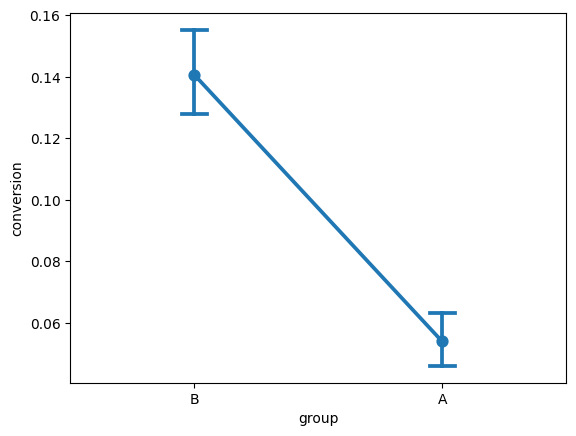

In [60]:
sns.pointplot(x='group', y='conversion', data=data, ci=95, capsize=.1)


Из полученных результатов видно, что конверсия группы __А__ составила 5.40 %, а конверсия группы __В__ - 14.07. Значит прирост (uplift) составил __8.67 процентных пункта__ или 8.67/5.40 = __160.6 %__

Теперь необходимо проанализировать статистическую значимость полученных результатов и на основе этого уже принимать или отвергать нулевую гипотезу Н0. Для этого будет использован Z-test, с помощью которого удастся определить значение p-value (вероятность получить такие или еще более выраженные различия). Установим опорное значение p-value = 0.05, что значит, если полученное значение p-value будет меньше 0.05, то увеличение конверсии в группе В является статичтически значимым, а, следовательно, мы можем отвергнуть нулевую гипотезу и сделать вывод, что новое оформление действительно положительно влияет на конверсию

In [56]:
from statsmodels.stats.proportion import proportions_ztest

converted_A = data[(data['group']=='A') & (data['conversion']==1)].shape[0] # число успешных конверсий в группе А
converted_B = data[(data['group'] == 'B') & (data['conversion']==1)].shape[0] # число успешных конверсий в группе В

total_A = data[data['group']=='A'].shape[0] # общее число наблюдений в группе А
total_B = data[data['group']=='B'].shape[0] # общее число наблюдений в группе В

success = [converted_A, converted_B]
total = [total_A, total_B]

z_stat, p_val = proportions_ztest(success, total)

print(f'z-stat: {z_stat}')
print(f'p-value: {p_val:}')

z-stat: -10.354488520266216
p-value: 3.9931511894201938e-25


Значение p-value не привысило 0.05 (3.99*10^-25<0.05), следовательно мы можем отвергнуть нулевую гипотезу и сделать заключение о статистической значимости полученных изменений. Однако лучше также проверить влияние и вклад различных факторов на увеличение конверсии, например, платформы, с которой просматривалась страница или страны.

### Анализ влияния различных факторов на конверсию в контексте групп А и В

In [65]:
import statsmodels.formula.api as smf


model = smf.logit(
    formula='conversion ~ C(group) * C(device) + C(group) * C(location) + C(group) * time_spent',
    data=data
).fit()

model.summary()


Optimization terminated successfully.
         Current function value: 0.306408
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4988
Method:                           MLE   Df Model:                           11
Date:                Sun, 13 Apr 2025   Pseudo R-squ.:                 0.03779
Time:                        21:25:11   Log-Likelihood:                -1532.0
converged:                       True   LL-Null:                       -1592.2
Covariance Type:            nonrobust   LLR p-value:                 1.559e-20
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.5698      0.259     -9.920      0.000      -3.078      -2.062
C(group)[T.B]                                     0.8069      0.312      2.586      0.010       0.195       1.419
C(device)[T.Mobile]                              -0.1896      0.177     -1.071      0.284      -0.537       0.157
C(location)[T.Northern Ireland]                  -0.3464      0.244     -1.418      0.156      -0.825       0.132
C(location)[T.Scotland]                          -0.3645      0.240     -1.520      0.129      -0.834       0.106
C(location)[T.Wales]                             -0.4038      0.246     -1.639      0.101      -0.887       0.079
C(group)[T.B]:C(device)[T.Mobile]                 0.2203      0.212      1.041      0.298      -0.194       0.635
C(group)[T.B]:C(location)[T.Northern Ireland]     0.0610      0.296      0.206      0.837      -0.520       0.642
C(group)[T.B]:C(location)[T.Scotland]             0.3933      0.288      1.366      0.172      -0.171       0.957
C(group)[T.B]:C(location)[T.Wales]                0.4371      0.293      1.489      0.136      -0.138       1.012
time_spent                                        0.0003      0.001      0.376      0.707      -0.001       0.002
C(group)[T.B]:time_spent                         -0.0003      0.001     -0.365      0.715      -0.002       0.001
=================================================================================================================
"""

__Влияние device на конверсию__ <br>
C(device)[T.Mobile] = -0.1896 (p-value = 0.284) <br>
Результат статистически незначимый. Влияния девайса на конверсию не наблюдается. <br><br>

__Влияние location Ireland, Scotland, Wales на конверсию__ <br>
p-value > 0.1<br>
Результат статистически незначимый. Влияния страны на конверсию не наблюдается.<br><br>

__Итеракция C(group)[T.B]:C(device)[T.Mobile] и остальные__<br>
Итеракция = эффект девайса зависит от группы<br>
p-value > 0.1<br>
Результат статистически незначимый. Влияния итеракций на конверсию не наблюдается.<br><br>

__Влияние time_stamp на конверсию__ <br>
time_spent = 0.0003 (p-value = 0.707)<br>
Результат статистически незначимый. Влияния времени, проведенного на сайте на конверсию не наблюдается.<br>




## Вывод

По итогам анализа результатов А/В теста удалось выяснить, что конверсия тестовой группы по результатам эксперимента увеличилась на 8.67 процентных пункта. Удалось также доказать статистическую значимость полученных результатов, проведя Z-test. Также с помощью логистической регрессии удалось проанализировать влияние различных факторов на конверсию и по результатам исследования оказалось, что единственное что влияет на увеличение конверсии является принадлежность к группе В (тестовой), то есть к тем, кто видел новый дизайн сайта. Девайс, страна, а также время, проведенное на сайте не показали статистически значимых результатов при анализе их влияиния на конверсию. Проведя А/В тестирование и проанализировав результаты, удалось установить, что редизайн сайта положительно сказался на ключевой метрике, увеличив конверсию на 8.67 процентных пункта.